## First try at getting some data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [69]:
#Essentials
import numpy as np
import pandas as pd
import pickle
import re
import datetime as dt
from termcolor import colored

#API imports
from sodapy import Socrata

#SQL related
import psycopg2
import sqlite3
from sqlalchemy import create_engine
import pandas.io.sql as pd_sql

#Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from  statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import geopandas as gpd
import shapely
from shapely.geometry import Point
import fiona
import pysal as ps
from pysal.contrib.viz import mapping as maps
# import contextily as ctx

#Regression imports
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import ensemble, tree
from sklearn.model_selection import GridSearchCV
from sklearn import feature_selection as f_select
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve


#Nice to have
from sklearn.pipeline import make_pipeline

#Geography magic
import geocoder
import googlemaps

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 6
rcParams.update({'font.size': 14})

### Load all the data into an SQL database

In [3]:
# Set up the database connection
conn = psycopg2.connect(dbname="taxi_rides_db", user="auste_m")

In [4]:
# CREATE TABLE taxi_rides_clean (
#                             trip_id TEXT, 
#                             taxi_id TEXT, 
#                             trip_start_timestamp TIMESTAMP,
#                             trip_end_timestamp TIMESTAMP,
#                             trip_seconds INT,
#                             trip_miles FLOAT,
#                             pickup_census_tract TEXT,
#                             pickup_community_area TEXT,
#                             dropoff_census_tract TEXT,
#                             dropoff_community_area TEXT,
#                             fare FLOAT,
#                             tips FLOAT,
#                             tolls FLOAT,
#                             extras FLOAT,
#                             trip_total FLOAT,
#                             payment_type TEXT,
#                             company TEXT,
#                             pickup_centroid_latitude FLOAT,
#                             pickup_centroid_longitude FLOAT,
#                             pickup_centroid_location TEXT,
#                             dropoff_centroid_latitude FLOAT,
#                             dropoff_centroid_longitude FLOAT,
#                             dropoff_centroid_location TEXT
#                         );

In [5]:
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips.csv' DELIMITER ',' CSV HEADER;
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips_2016.csv' DELIMITER ',' CSV HEADER;
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips_2015.csv' DELIMITER ',' CSV HEADER;

In [6]:
# CREATE TABLE chicago_weather(
#                                 station TEXT,
#                                 name TEXT, 
#                                 latitude FLOAT,
#                                 longitude FLOAT,
#                                 elevation FLOAT,
#                                 date TIMESTAMP, 
#                                 avg_daily_wind_speed FLOAT,
#                                 peak_gust_time FLOAT,
#                                 precipitation_mm FLOAT,
#                                 snowfall_mm FLOAT,
#                                 snowdepth_mm FLOAT,
#                                 avg_temp_f INT,
#                                 fog INT,
#                                 heavy_fog INT,
#                                 thunder INT,
#                                 sleet INT,
#                                 hail INT, 
#                                 glaze INT,
#                                 smoke INT,
#                                 drifting_snow INT, 
#                                 mist INT,
#                                 drizzle INT,
#                                 rain INT,
#                                 freezing_rain INT,
#                                 snow INT,
#                                 unkwn_precipitation INT,
#                                 ice_fog INT
#                                  );

In [7]:
# COPY chicago_weather FROM '/home/ubuntu/Chicago_Historical_Weather_Dataset.csv' DELIMITER ',' CSV HEADER;

In [8]:
# taxi_rides_query = """SELECT * FROM taxi_rides WHERE trip_start_timestamp BETWEEN '2016-02-01' AND '2016-02-15';""" 
# weather_query = """SELECT * FROM chicago_weather WHERE date BETWEEN '2016-02-01' AND '2016-02-15';"""

taxi_weather_query = """SELECT TR.trip_start_timestamp,
                                TR.trip_end_timestamp,
                                TR.trip_seconds,
                                TR.trip_miles,
                                --TR.pickup_community_area,
                                --TR.dropoff_community_area,
                                --TR.fare,
                                --TR.tolls,
                                CASE WHEN TR.tolls IS NULL THEN TR.fare ELSE TR.fare + TR.tolls END as fare_with_tolls,
                                --TR.tips,
                                --TR.trip_total,
                                TR.payment_type,
                                TR.pickup_centroid_latitude,
                                TR.pickup_centroid_longitude,
                                TR.pickup_centroid_location,
                                TR.dropoff_centroid_latitude,
                                TR.dropoff_centroid_longitude,
                                TR.dropoff_centroid_location,
                                CW.avg_daily_wind_speed,
                                CW.avg_temp_f,
                                CASE WHEN CW.fog = 1 OR CW.heavy_fog = 1 OR ice_fog = 1 OR mist = 1 THEN 1 ELSE 0 END as fog,
                                CASE WHEN CW.rain = 1 OR CW.drizzle = 1 OR CW.hail = 1 THEN 1 ELSE 0 END as rain,
                                CASE WHEN CW.snow = 1 OR CW.freezing_rain = 1 OR drifting_snow = 1 THEN 1 ELSE 0 END as snow
                                
                        FROM taxi_rides_clean as TR
                        LEFT JOIN chicago_weather as CW
                        ON CAST(TR.trip_start_timestamp AS DATE) = CAST(date AS DATE)
                        WHERE trip_start_timestamp BETWEEN '2016-01-01' AND '2016-12-31';""" 

In [9]:
#Read in Chicago city community area shapefile
# chicago_community_areas = gpd.read_file("./datasets/Chicago_Community_Areas/geo_export_4c20eda0-2d92-4a1d-8513-878eb3e095a3.shp")

In [10]:
#approx. 30min to load the whole of 2016 data
sql_load = pd.read_sql_query(taxi_weather_query, con=conn)

In [11]:
taxi_weather_df = sql_load

In [12]:
taxi_weather_df.describe()

,trip_seconds,trip_miles,fare_with_tolls,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
count,1.984338e+07,1.984637e+07,1.984630e+07,1.709229e+07,1.709229e+07,1.680043e+07,1.680043e+07,1.984660e+07,1.984660e+07,1.984660e+07,1.984660e+07,1.984660e+07
mean,7.672117e+02,3.396201e+00,1.389773e+01,4.190086e+01,-8.765908e+01,4.190089e+01,-8.765378e+01,9.746638e+00,5.261917e+01,4.426738e-01,2.585934e-03,3.020366e-03
std,1.060590e+03,2.262366e+01,2.542274e+01,3.776937e-02,7.354971e-02,3.786307e-02,5.911833e-02,3.765608e+00,1.985110e+01,4.967028e-01,5.078629e-02,5.487480e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,4.166014e+01,-8.791362e+01,4.166014e+01,-8.791362e+01,3.130000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+02,1.000000e-01,6.250000e+00,4.188099e+01,-8.765588e+01,4.188099e+01,-8.765600e+01,6.930000e+00,3.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.400000e+02,1.100000e+00,8.500000e+00,4.189251e+01,-8.763275e+01,4.189251e+01,-8.763275e+01,9.170000e+00,5.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,9.000000e+02,2.700000e+00,1.425000e+01,4.190586e+01,-8.762615e+01,4.191462e+01,-8.762621e+01,1.208000e+01,7.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00
max,8.639900e+04,3.353100e+03,9.999000e+03,4.202122e+01,-8.753490e+01,4.202122e+01,-8.753490e+01,2.662000e+01,8.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00


> Original number of records for 1st-15th February 2016: **831,790**  
> Original number of records for the whole of 2016: **19,846,602**

In [13]:
#Let's explore the dataset
null_records = taxi_weather_df[(taxi_weather_df['pickup_centroid_latitude'].isnull()) | (taxi_weather_df['pickup_centroid_longitude'].isnull()) | 
                (taxi_weather_df['dropoff_centroid_latitude'].isnull()) | (taxi_weather_df['dropoff_centroid_longitude'].isnull()) | 
                (taxi_weather_df['trip_seconds'].isnull()) | (taxi_weather_df['trip_miles'].isnull()) | 
                (taxi_weather_df['fare_with_tolls'].isnull())]['trip_start_timestamp'].count()

print(f'There are {null_records} records with a null value in at least one of the fields mentioned above.')

There are 3189786 records with a null value in at least one of the fields mentioned above.


## Sweeping time!

In [14]:
taxi_weather_df.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,2016-01-01 15:00:00,2016-01-01 15:15:00,840.0,2.1,9.45,Credit Card,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.899156,-87.626211,POINT (-87.6262105324 41.8991556134),14.32,23,0,0,0
1,2016-01-01 16:00:00,2016-01-01 16:00:00,360.0,0.5,5.65,Cash,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),14.32,23,0,0,0
2,2016-01-01 02:30:00,2016-01-01 02:30:00,600.0,1.7,7.65,Cash,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),14.32,23,0,0,0
3,2016-01-01 15:15:00,2016-01-01 15:15:00,660.0,3.0,9.65,Cash,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),14.32,23,0,0,0
4,2016-01-01 22:45:00,2016-01-01 22:45:00,420.0,1.7,6.85,Cash,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),14.32,23,0,0,0


In [15]:
#Change payment type to boolean
taxi_weather_df['payment_type'] = pd.Categorical(taxi_weather_df['payment_type'])

In [16]:
#Let's drop all the records with a missing lat / long in either pickup or dropoff
taxi_weather_clean = taxi_weather_df.dropna(subset=['pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude'
                                                    , 'dropoff_centroid_longitude', 'trip_seconds', 'trip_miles', 'fare_with_tolls'])

In [17]:
taxi_weather_clean.head(2)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,2016-01-01 15:00:00,2016-01-01 15:15:00,840.0,2.1,9.45,Credit Card,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.899156,-87.626211,POINT (-87.6262105324 41.8991556134),14.32,23,0,0,0
1,2016-01-01 16:00:00,2016-01-01 16:00:00,360.0,0.5,5.65,Cash,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),14.32,23,0,0,0


In [18]:
taxi_weather_clean[['fog', 'rain', 'snow']] = taxi_weather_clean[['fog', 'rain', 'snow']].fillna(value=0)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [19]:
taxi_weather_clean.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,2016-01-01 15:00:00,2016-01-01 15:15:00,840.0,2.1,9.45,Credit Card,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.899156,-87.626211,POINT (-87.6262105324 41.8991556134),14.32,23,0,0,0
1,2016-01-01 16:00:00,2016-01-01 16:00:00,360.0,0.5,5.65,Cash,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),14.32,23,0,0,0
2,2016-01-01 02:30:00,2016-01-01 02:30:00,600.0,1.7,7.65,Cash,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),14.32,23,0,0,0
3,2016-01-01 15:15:00,2016-01-01 15:15:00,660.0,3.0,9.65,Cash,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),14.32,23,0,0,0
4,2016-01-01 22:45:00,2016-01-01 22:45:00,420.0,1.7,6.85,Cash,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),14.32,23,0,0,0


In [20]:
taxi_weather_clean.count()[0]

16656816

> Remaining number of records after removing missing values containing records for 1st-15th February 2016: **81%** (673,474)  
> Remaining number of records after removing missing values containing records for whole 2016: **84%** (16,656,816)

In [21]:
#Check how many records where removed by taking out zero value rows for fare, trip_seconds and trip_miles #139,699
# taxi_weather_clean[(taxi_weather_clean['fare_with_tolls'] == 0.0) 
#                                           | (taxi_weather_clean['trip_seconds'] == 0.0) 
#                                           | (taxi_weather_clean['trip_miles'] == 0.0)].count()

In [22]:
#Let's get rid of the zeroes
taxi_weather_clean = taxi_weather_clean[(taxi_weather_clean['fare_with_tolls'] != 0.0) 
                                          & (taxi_weather_clean['trip_seconds'] != 0.0) 
                                          & (taxi_weather_clean['trip_miles'] != 0.0)]

In [23]:
taxi_weather_clean.count()[0]

13354486

> Remaining number of records after null and zero value removal for 1st-15th February 2016: **64%** (533,775)   
> Remaining number of records after null and zero value removal for the whole 2016: **67%** (13,354,486)

In [24]:
#Since taxi fare doesn't automatically include tolls, to get a base rate, I need to add tolls to the fare
# taxi_weather_clean['fare_with_tolls'] = taxi_weather_clean['fare'] + taxi_weather_clean['tolls']

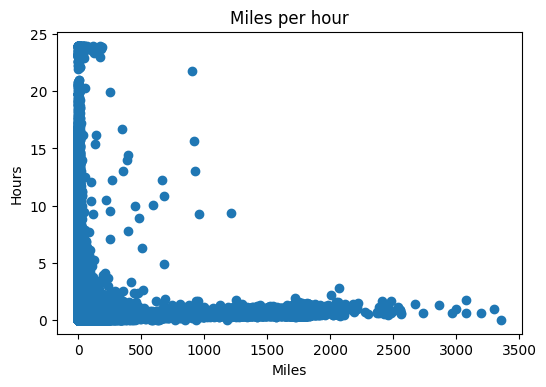

In [25]:
#Let's have a look if the miles per minute look reasonable
plt.figure(dpi=100)
plt.scatter(taxi_weather_clean['trip_miles'], taxi_weather_clean['trip_seconds'] / 3600.0)
plt.title('Miles per hour')
plt.xlabel('Miles')
plt.ylabel('Hours');

In [26]:
miles_per_hour = taxi_weather_clean['trip_miles'] / (taxi_weather_clean['trip_seconds'] / 3600.0)

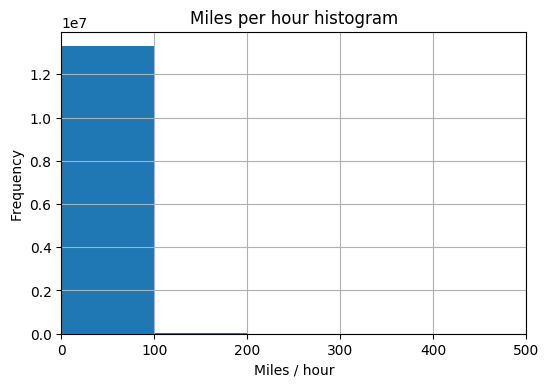

In [27]:
plt.figure(dpi=100)
miles_per_hour.hist(bins=10000)
plt.xlim(xmin=0.0, xmax=500.0)
plt.title('Miles per hour histogram')
plt.xlabel('Miles / hour')
plt.ylabel('Frequency');

In [28]:
#Looking at the data and also from a logical perspective, I've decided to filter out any rides with miles / hour higher than 100
miles_per_hour[miles_per_hour > 100.0].count()

52624

In [29]:
#Removing clear error records from the dataset (e.g. $1,000 for 0.1 mile and 6 min ride). Settling at max 100 miles an hour
taxi_weather_clean = taxi_weather_clean[(taxi_weather_clean['trip_miles'] / (taxi_weather_clean['trip_seconds'] / 3600.0)) <= 100.0]

In [30]:
taxi_weather_clean.count()[0]

13301862

> Number of records excluded by removing instances with speed higher than 100: **%** ()  
> Number of records remaining (whole 2016): **67%** (13,301,862)

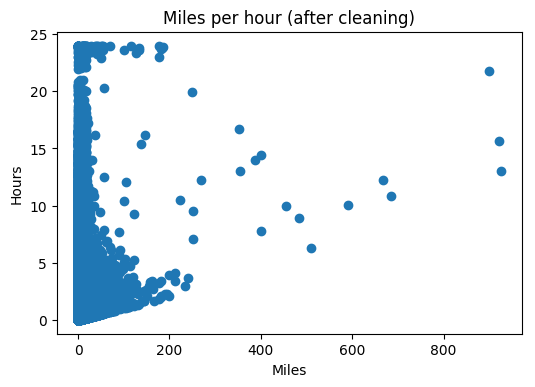

In [31]:
#Let's have a look if the miles per minute look reasonable
plt.figure(dpi=100)
plt.scatter(taxi_weather_clean['trip_miles'], taxi_weather_clean['trip_seconds'] / 3600.0)
plt.title('Miles per hour (after cleaning)')
plt.xlabel('Miles')
plt.ylabel('Hours');

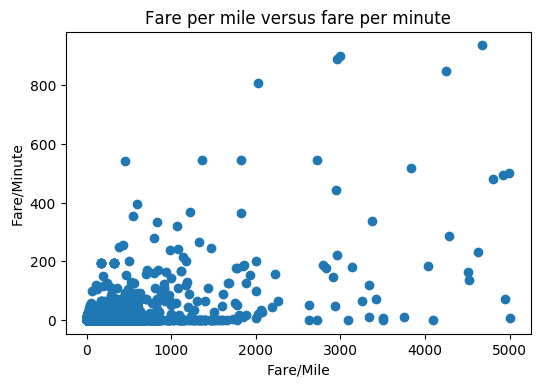

In [32]:
#Let's see that's the distribution of $/mile to better identify incorrect values
fare_per_mile = taxi_weather_clean['fare_with_tolls'] / taxi_weather_clean['trip_miles']
fare_per_minute = taxi_weather_clean['fare_with_tolls'] / (taxi_weather_clean['trip_seconds'] / 60)

#Removing obvious outliers
outlier_indices = list((fare_per_mile[fare_per_mile > 5000]).index)
fare_per_mile = fare_per_mile.drop(index=outlier_indices)
fare_per_minute = fare_per_minute.drop(index=outlier_indices)

plt.figure(dpi=100)
plt.scatter(fare_per_mile, fare_per_minute)
plt.title('Fare per mile versus fare per minute')
plt.xlabel('Fare/Mile')
plt.ylabel('Fare/Minute');

In [33]:
#Check how many records are being excluded due to below rules
taxi_weather_clean[((taxi_weather_clean['fare_with_tolls'] / taxi_weather_clean['trip_miles']) > 50) |
                                 ((taxi_weather_clean['fare_with_tolls'] / (taxi_weather_clean['trip_seconds'] / 60.0)) > 250)].count()[0]

958063

In [34]:
#Based on above analysis, I'm setting a max fare/mile at $250 and max fare/minute to $50
taxi_weather_clean = taxi_weather_clean[((taxi_weather_clean['fare_with_tolls'] / taxi_weather_clean['trip_miles']) <= 50) &
                                 ((taxi_weather_clean['fare_with_tolls'] / (taxi_weather_clean['trip_seconds'] / 60.0)) <= 250)]

In [35]:
taxi_weather_clean.count()[0]

12343799

> Number of records excluded by removing instances of fare/mile of more than USD 250 and fare/minute of more than USD 50: **8%** (39,999)  
> Number of records remaining: **62%** (12,343,799)

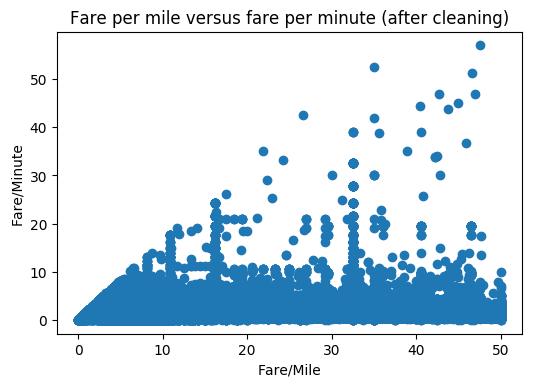

In [36]:
#Let's see that's the distribution of $/mile to better identify incorrect values
fare_per_mile = taxi_weather_clean['fare_with_tolls'] / taxi_weather_clean['trip_miles']
fare_per_minute = taxi_weather_clean['fare_with_tolls'] / (taxi_weather_clean['trip_seconds'] / 60)


#Replot to see the effect
plt.figure(dpi=100)
plt.scatter(fare_per_mile, fare_per_minute)
plt.title('Fare per mile versus fare per minute (after cleaning)')
plt.xlabel('Fare/Mile')
plt.ylabel('Fare/Minute');

In [37]:
# with open('clean_taxi_weather_dataset.pkl', 'wb') as clean_pickle:
#     pickle.dump(taxi_weather_clean, clean_pickle)

In [38]:
# with open('clean_taxi_weather_dataset.pkl', 'rb') as clean_pickle:
#     taxi_weather_clean = pickle.load(clean_pickle)

## Analysis Time!

In [39]:
#Let's explore the tips and tolls columns
taxi_weather_clean.groupby(['payment_type'])['trip_miles'].describe()

,count,mean,std,min,25%,50%,75%,max
payment_type,,,,,,,,
Cash,6569175.0,2.975687,4.269939,0.01,0.90,1.5,3.00,925.0
Credit Card,5686731.0,4.695055,5.801658,0.07,1.00,1.9,5.20,113.7
Dispute,8624.0,3.822611,4.878905,0.10,1.00,1.8,4.10,48.2
No Charge,59565.0,3.370016,4.282545,0.10,1.00,1.7,3.70,89.4
Pcard,2669.0,3.280821,3.088998,0.10,1.20,2.2,4.50,21.0
Prcard,2988.0,2.910950,2.617084,0.10,1.01,1.7,4.12,19.7
Unknown,14047.0,3.173781,2.806798,0.10,1.00,2.3,4.80,49.7
Way2ride,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> On average, trips paid with a credit card had longer distance, and therefore, longer duration and higher fare. However, I'm not going to use payment_type as a variable, since it's not relevant

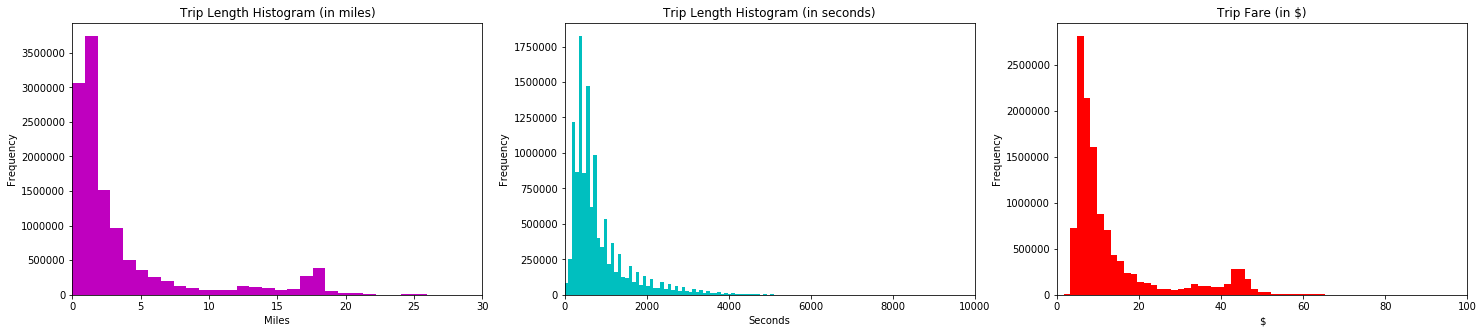

In [40]:
#Let's explore the distribution of variables of interest
plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.hist(taxi_weather_clean['trip_miles'], bins=1000, color='m')
plt.title('Trip Length Histogram (in miles)')
plt.xlim(xmin=0, xmax=30)
plt.xlabel('Miles')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(taxi_weather_clean['trip_seconds'], bins=1000, color='c')
plt.title('Trip Length Histogram (in seconds)')
plt.xlim(xmin=0, xmax=10000)
plt.xlabel('Seconds')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(taxi_weather_clean['fare_with_tolls'], bins=5000, color='r')
plt.title('Trip Fare (in $)')
plt.xlim(xmin=0, xmax=100)
plt.xlabel('$')
plt.ylabel('Frequency');

> Will be having some logging fun!

## Let's check out the Time Series fun

In [41]:
taxi_weather_clean['pickup_date'] = taxi_weather_clean['trip_start_timestamp'].dt.date
taxi_weather_clean['pickup_time'] = taxi_weather_clean['trip_start_timestamp'].dt.time
taxi_weather_clean['pickup_time_formatted'] = [time.strftime("%H:%M") for time in taxi_weather_clean['pickup_time']]
taxi_weather_clean['pickup_weekday'] = taxi_weather_clean['trip_start_timestamp'].dt.weekday      #Monday is 0
taxi_weather_clean['pickup_weekday_name'] = taxi_weather_clean['trip_start_timestamp'].dt.weekday_name

In [42]:
taxi_weather_clean.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,...,avg_daily_wind_speed,avg_temp_f,fog,rain,snow,pickup_date,pickup_time,pickup_time_formatted,pickup_weekday,pickup_weekday_name
0,2016-01-01 15:00:00,2016-01-01 15:15:00,840.0,2.1,9.45,Credit Card,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.899156,...,14.32,23,0,0,0,2016-01-01,15:00:00,15:00,4,Friday
1,2016-01-01 16:00:00,2016-01-01 16:00:00,360.0,0.5,5.65,Cash,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.892073,...,14.32,23,0,0,0,2016-01-01,16:00:00,16:00,4,Friday
2,2016-01-01 02:30:00,2016-01-01 02:30:00,600.0,1.7,7.65,Cash,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.885300,...,14.32,23,0,0,0,2016-01-01,02:30:00,02:30,4,Friday
3,2016-01-01 15:15:00,2016-01-01 15:15:00,660.0,3.0,9.65,Cash,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.922686,...,14.32,23,0,0,0,2016-01-01,15:15:00,15:15,4,Friday
4,2016-01-01 22:45:00,2016-01-01 22:45:00,420.0,1.7,6.85,Cash,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,...,14.32,23,0,0,0,2016-01-01,22:45:00,22:45,4,Friday


## How about fares by the date variables (day, weekday, time)?

In [43]:
#Creating pandas series for days, time and weekday
avg_pickup_fare_per_mile_over_days = taxi_weather_clean.groupby(['pickup_date'])['fare_with_tolls'].sum() / taxi_weather_clean.groupby(['pickup_date'])['trip_miles'].sum()
avg_pickup_fare_per_mile_by_time = taxi_weather_clean.groupby(['pickup_time'])['fare_with_tolls'].sum() / taxi_weather_clean.groupby(['pickup_time'])['trip_miles'].sum()
avg_pickup_fare_per_mile_by_weekday = taxi_weather_clean.groupby(['pickup_weekday'])['fare_with_tolls'].sum() / taxi_weather_clean.groupby(['pickup_weekday'])['trip_miles'].sum()
                                    

(3.4, 4.0)

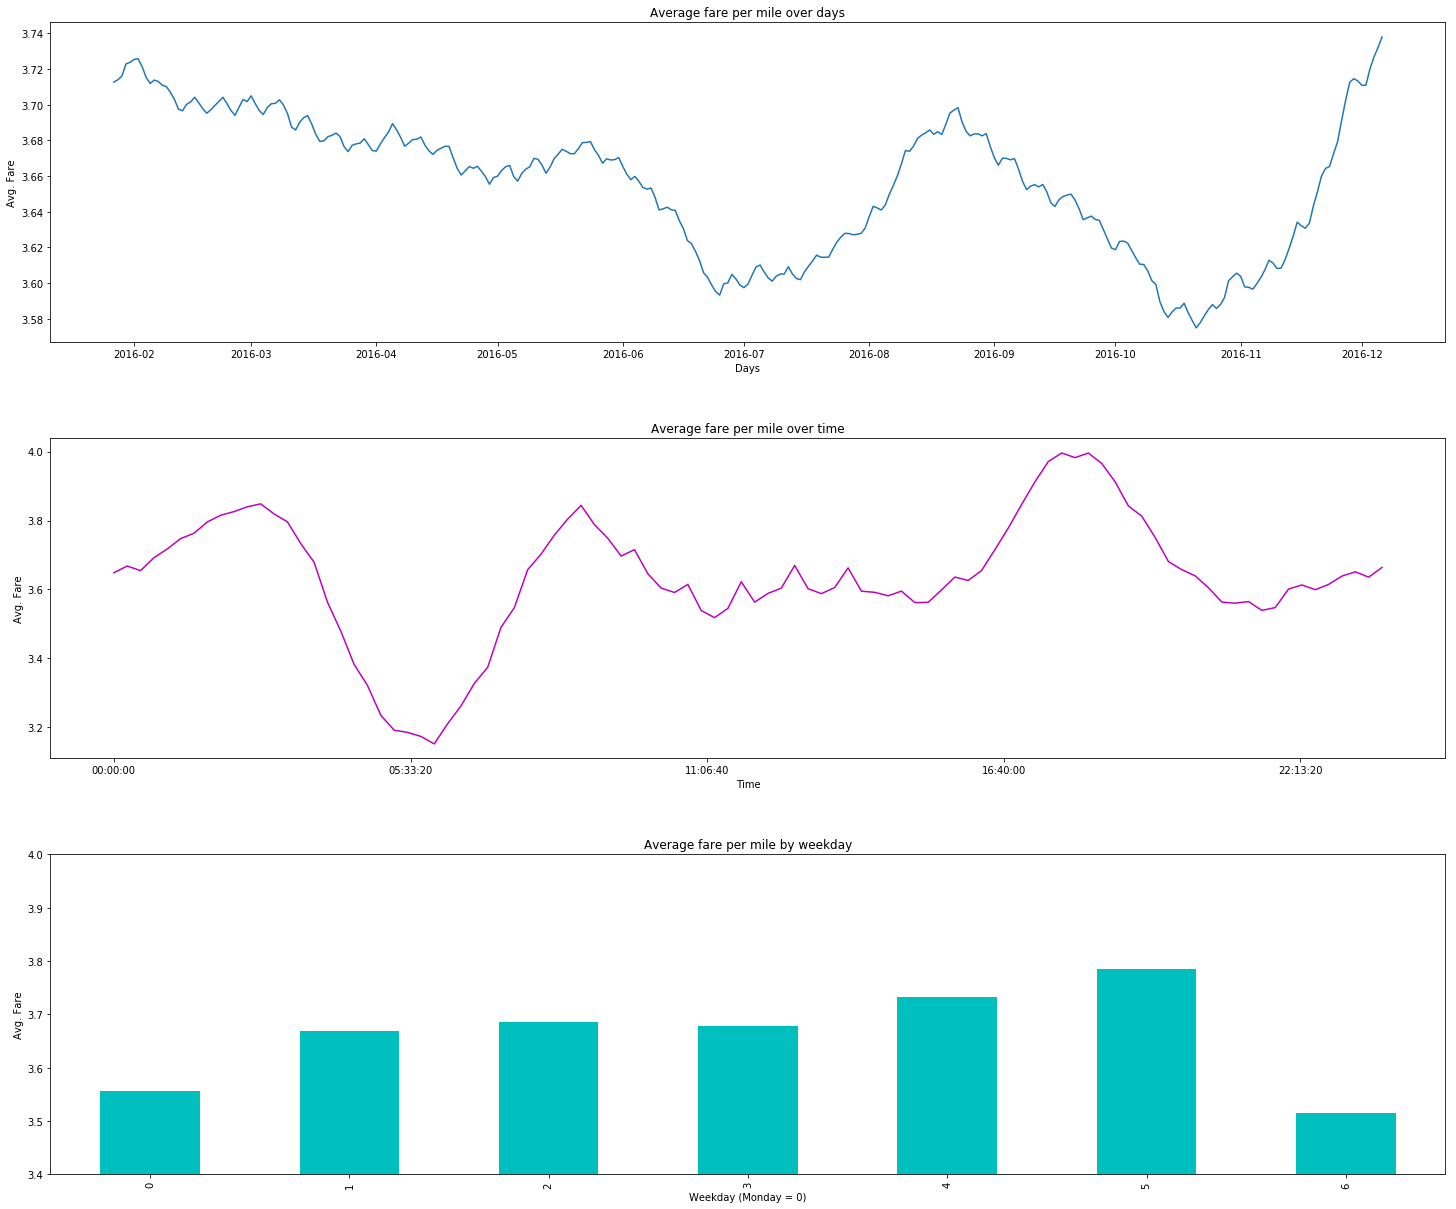

In [44]:
plt.figure(figsize=(25, 20))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                wspace=0.2, hspace=0.3)

avg_pickup_fare_per_mile_over_days_R52 = avg_pickup_fare_per_mile_over_days.rolling(52, center=True).mean()

plt.subplot(3, 1, 1)
avg_pickup_fare_per_mile_over_days_R52.plot()
plt.title('Average fare per mile over days')
plt.xlabel('Days')
plt.ylabel('Avg. Fare')

plt.subplot(3, 1, 2)
avg_pickup_fare_per_mile_by_time.plot(color='m')
plt.title('Average fare per mile over time')
plt.xlabel('Time')
plt.ylabel('Avg. Fare')

plt.subplot(3, 1, 3)
avg_pickup_fare_per_mile_by_weekday.plot(color='c',kind='bar')
plt.title('Average fare per mile by weekday')
plt.xlabel('Weekday (Monday = 0)')
plt.ylabel('Avg. Fare');
plt.ylim(3.4,4.0)

> * Average fare across the year has been increasing from January to June, dips in summer then spikes again in October / November and dips again in December. It is strange that the average fare would drop so much in December, since it's an average.  
> * Weekday certainly has an impact on the fare, therefore I will be treating the weekday feature as a separate variable in the modelling  
> * There's something strange going on in the data between 5am and 7am. Seems like there were a few long distance (high fare) trips around this time. After noticing this, I change the measure from avg. fare to avg. fare per mile.
> * Looking at the first two charts, I certainly need to do some differencing to make my time series data more stationary.


### Zooming in on 5am-7am period

In [45]:
taxi_weather_5_7am = taxi_weather_clean[(taxi_weather_clean['pickup_time'] >= dt.time(5,0,0)) &
                                         (taxi_weather_clean['pickup_time'] <= dt.time(7,0,0))]

# taxi_weather_5_7am = taxi_weather_5_7am.groupby(['pickup_time'])['fare_with_tolls'].max()

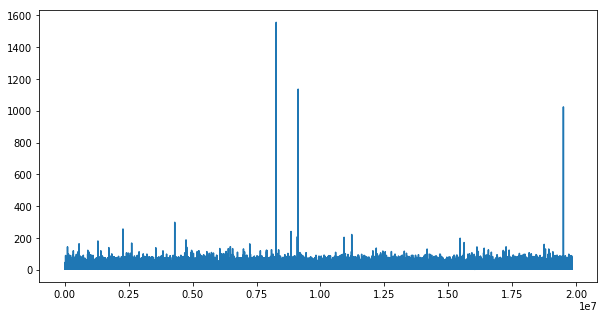

In [46]:
plt.figure(figsize=(10, 5))
taxi_weather_5_7am['fare_with_tolls'].plot();

In [47]:
taxi_weather_5_7am[taxi_weather_5_7am['fare_with_tolls'] >= 1000.0]

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,...,avg_daily_wind_speed,avg_temp_f,fog,rain,snow,pickup_date,pickup_time,pickup_time_formatted,pickup_weekday,pickup_weekday_name
8270113,2016-05-14 06:45:00,2016-05-14 19:00:00,44100.0,667.1,1556.75,Cash,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.965812,...,13.87,46,0,0,0,2016-05-14,06:45:00,06:45,5,Saturday
9129803,2016-05-28 06:30:00,2016-05-28 15:15:00,32160.0,482.7,1136.00,Cash,41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),41.857184,...,14.54,73,1,0,0,2016-05-28,06:30:00,06:30,5,Saturday
19505963,2016-12-19 06:45:00,2016-12-19 16:00:00,33420.0,122.5,1024.34,Cash,41.829922,-87.672503,POINT (-87.6725026464 41.8299223039),41.901207,...,12.08,-1,0,0,0,2016-12-19,06:45:00,06:45,0,Monday


> These records seem legitimate, since they have high mileage and hence high fare.

### Serious Time Series stuff, examining demand over time

In [48]:
taxi_weather_clean.head(2)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,...,avg_daily_wind_speed,avg_temp_f,fog,rain,snow,pickup_date,pickup_time,pickup_time_formatted,pickup_weekday,pickup_weekday_name
0,2016-01-01 15:00:00,2016-01-01 15:15:00,840.0,2.1,9.45,Credit Card,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.899156,...,14.32,23,0,0,0,2016-01-01,15:00:00,15:00,4,Friday
1,2016-01-01 16:00:00,2016-01-01 16:00:00,360.0,0.5,5.65,Cash,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.892073,...,14.32,23,0,0,0,2016-01-01,16:00:00,16:00,4,Friday


### Looking at the demand over time

In [49]:
demand_over_time = taxi_weather_clean.groupby(['trip_start_timestamp'])['trip_start_timestamp'].count()
demand_over_days = taxi_weather_clean.groupby(['pickup_date'])['pickup_date'].count()
demand_by_15min = taxi_weather_clean.groupby(['pickup_time'])['pickup_time'].count()
demand_by_weekday = taxi_weather_clean.groupby(['pickup_weekday'])['pickup_weekday'].count()

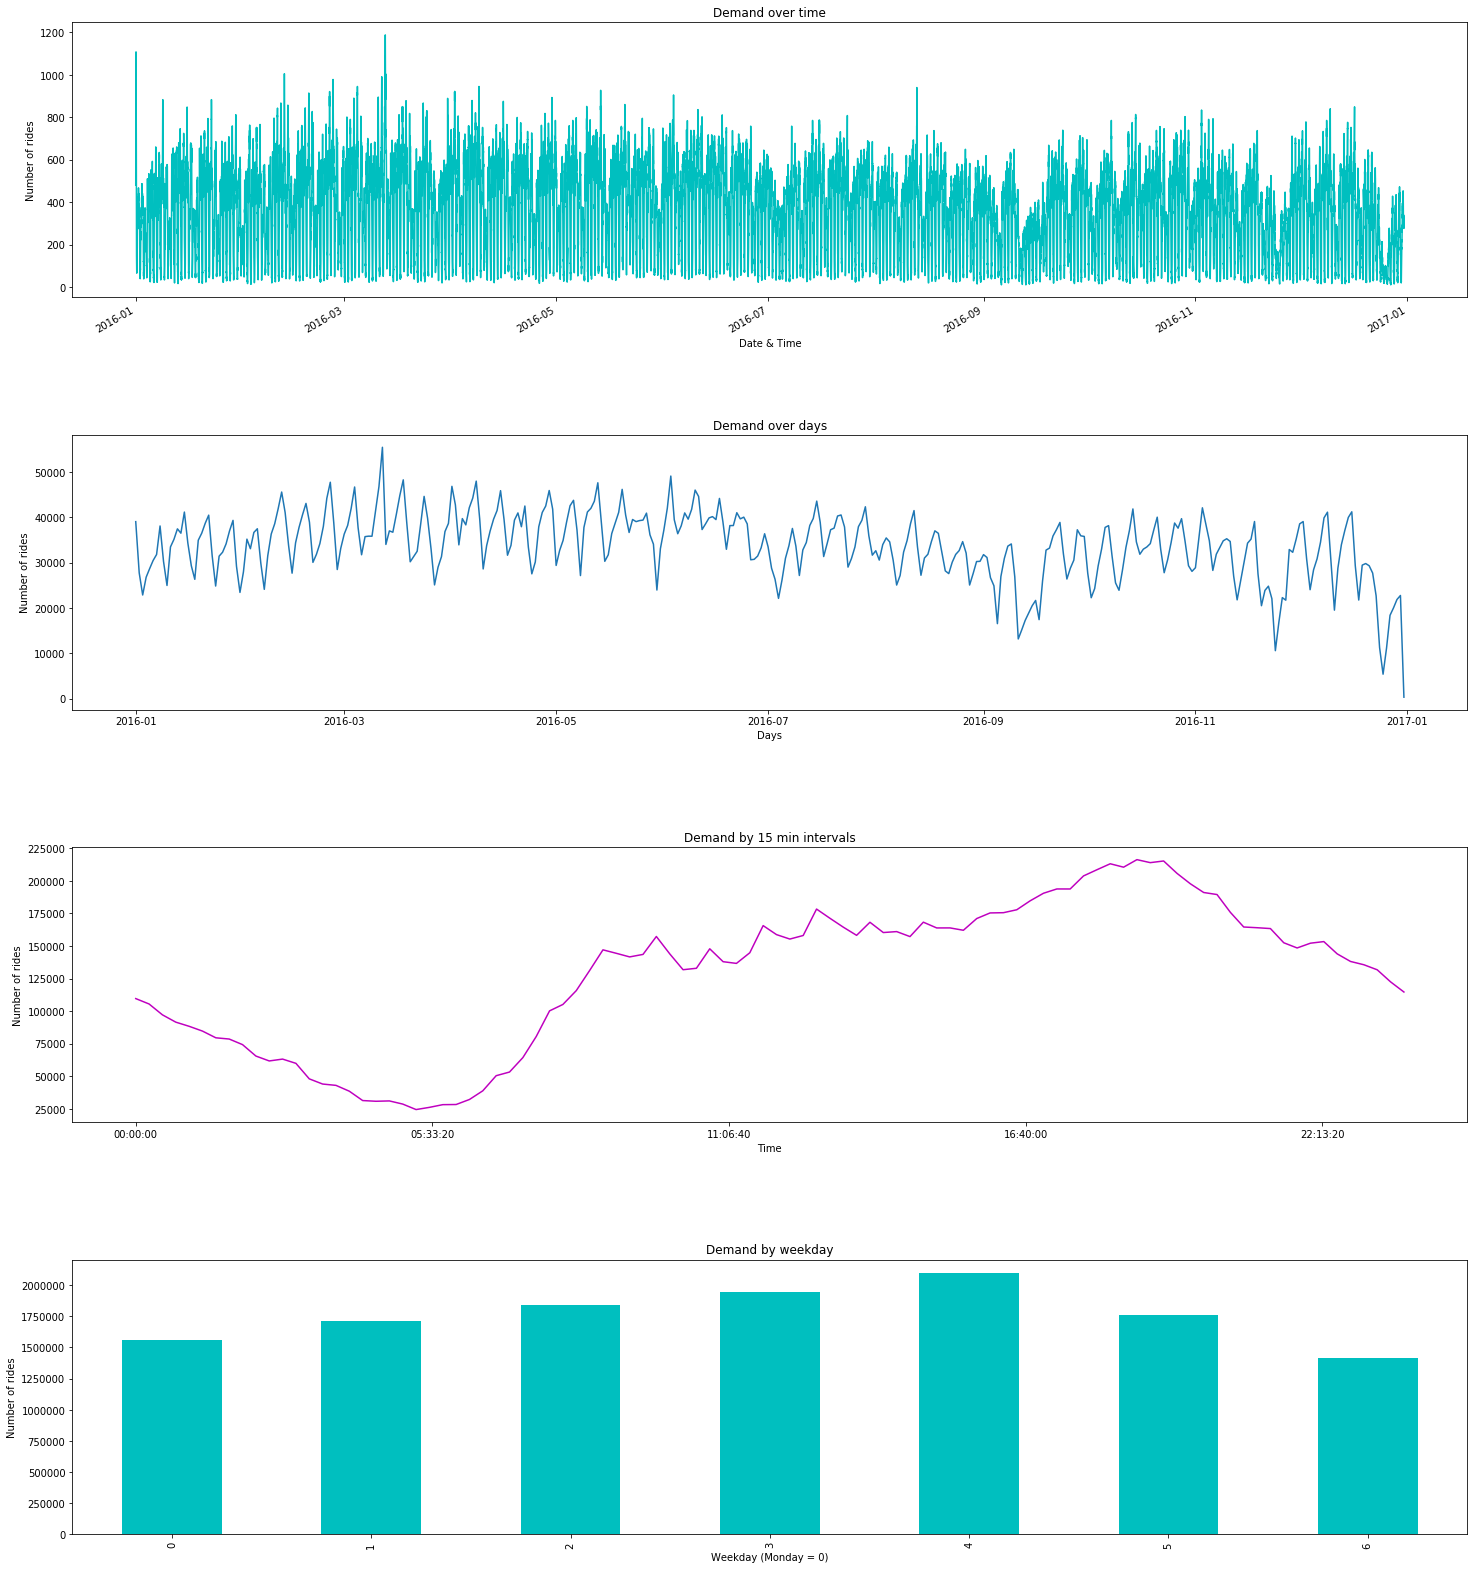

In [50]:
plt.figure(figsize=(25, 30))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                wspace=0.2, hspace=0.5)

plt.subplot(4, 1, 1)
demand_over_time.plot(color='c')
plt.title('Demand over time')
plt.xlabel('Date & Time')
plt.ylabel('Number of rides')

plt.subplot(4, 1, 2)
demand_over_days.plot()
plt.title('Demand over days')
plt.xlabel('Days')
plt.ylabel('Number of rides')

plt.subplot(4, 1, 3)
demand_by_15min.plot(color='m')
plt.title('Demand by 15 min intervals')
plt.xlabel('Time')
plt.ylabel('Number of rides')

plt.subplot(4, 1, 4)
demand_by_weekday.plot(color='c', kind='bar')
plt.title('Demand by weekday')
plt.xlabel('Weekday (Monday = 0)')
plt.ylabel('Number of rides');

> There is clearly a weekly pattern where Monday and Sunday seem to have the lowest demand (need to verify that, since it's a little surpising)  
> There is also a clear pattern in number of rides during the day, with spikes at peak hours, especially the afternoon peak and being slow early in the morning

### Understanding the stationarity of my timeseries data

#### Helper Function

In [51]:
def test_stationarity(timeseries):   
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    timeseries.dropna(inplace=True)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(demand_over_time)

Results of Dickey-Fuller Test:
Test Statistic                   -27.607244
p-value                            0.000000
#Lags Used                        52.000000
Number of Observations Used    34984.000000
Critical Value (1%)               -3.430537
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64


> Since p-value is higher than 0.05, I cannot reject null hypothesis that the data is not stationare  
> The test result suggests that I need to do **differencing**

In [52]:
print('Differencing over Days:')
print('0 diffs:', demand_over_time.std())
print('1 diffs:', demand_over_time.diff().std())
print('2 diffs:', demand_over_time.diff().diff().std())
print('3 diffs:', demand_over_time.diff().diff().diff().std())

Differencing over Days:
0 diffs: 205.39763919185893
1 diffs: 37.35685493181032
2 diffs: 53.898564242103426
3 diffs: 94.9022530611681


> Differencing **once** seems to be the right call for both dates and times

In [53]:
#So let's do it
demand_over_time_diffed = demand_over_time.diff()
demand_over_time_diffed = demand_over_time_diffed[1:]

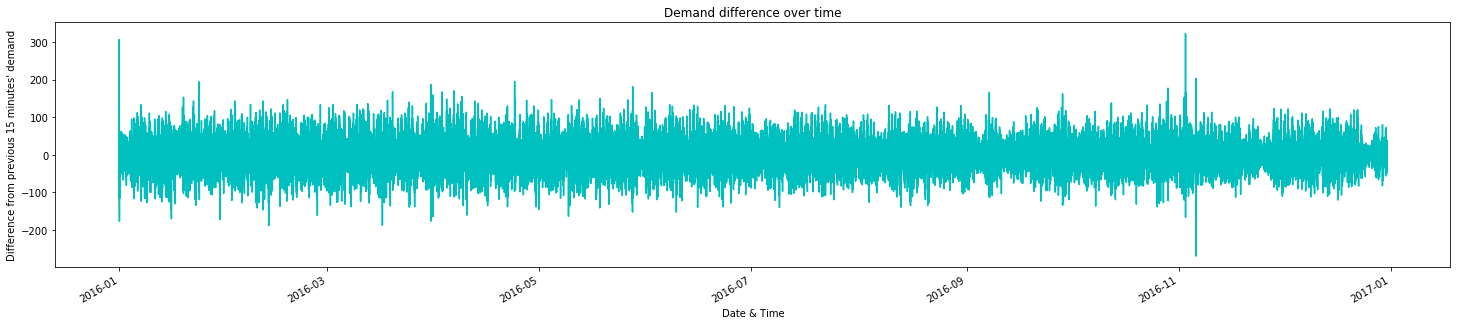

In [54]:
plt.figure(figsize=(25, 5))
demand_over_time_diffed.plot(color='c')
plt.title('Demand difference over time')
plt.xlabel('Date & Time')
plt.ylabel("Difference from previous 15 minutes' demand");

In [55]:
#What's the stationarity score like after differencing?
test_stationarity(demand_over_time_diffed)

Results of Dickey-Fuller Test:
Test Statistic                   -42.872677
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    34986.000000
Critical Value (1%)               -3.430537
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64


> Much better now!

**Now check out how many lags to look back at (remember it's based on 15min time periods)**

Figure(432x288)


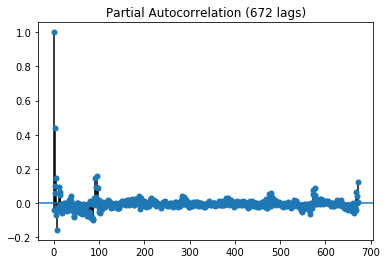

In [56]:
#Partial Autocorrelation plots will help to evaluate how many lags to include as features
print(plot_pacf(demand_over_time_diffed.dropna(), lags=672, title='Partial Autocorrelation (672 lags)'))

> According to the Partial correlation plot, taking **7 first lags, 96th and 672th lags** is the way to go (last 1h 45min, same time yesterday and same time the week ago)

### Fancy visualization :)

In [57]:
time_map = taxi_weather_clean.pivot_table(index='pickup_time_formatted', columns=['pickup_weekday'], values='avg_temp_f', aggfunc='count')

<Figure size 432x288 with 0 Axes>

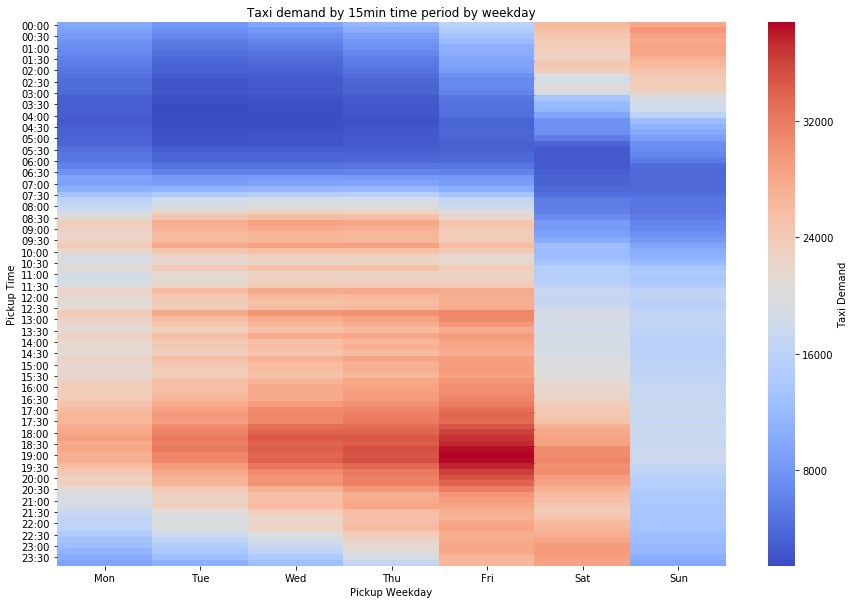

In [58]:
heatmap = plt.figure()
plt.figure(figsize=(15,10))

ax = sns.heatmap(time_map, annot=False, xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], cmap='coolwarm', cbar_kws={'label':'Taxi Demand'})
plt.title('Taxi demand by 15min time period by weekday')
ax.set(xlabel='Pickup Weekday', ylabel='Pickup Time');

# plt.savefig('Taxi_Demand_Heatmap.png', bbox_inches='tight');

In [147]:
#Let's create 7 lags
demand = pd.DataFrame(demand_over_time_diffed)
demand.rename(columns={'trip_start_timestamp': 'demand'}, inplace=True)
demand = demand.reset_index()
demand = demand.set_index(['trip_start_timestamp'])

#Create lags
demand['demand_lag1'] = demand['demand'].shift(1)
demand['demand_lag2'] = demand['demand'].shift(2)
demand['demand_lag3'] = demand['demand'].shift(3)
demand['demand_lag4'] = demand['demand'].shift(4)
demand['demand_lag5'] = demand['demand'].shift(5)
demand['demand_lag6'] = demand['demand'].shift(6)
demand['demand_lag7'] = demand['demand'].shift(7)
demand['demand_lag96'] = demand['demand'].shift(96)
demand['demand_lag672'] = demand['demand'].shift(672)

In [148]:
demand.head(3)

,demand,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6,demand_lag7,demand_lag96,demand_lag672
trip_start_timestamp,,,,,,,,,,
2016-01-01 00:15:00,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 00:30:00,63.0,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 00:45:00,-57.0,63.0,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Separating out a dataset for testing**

In [149]:
demand_jan_mar = demand[(demand.index >= pd.to_datetime('2016-01-01 00:00:00')) & 
                       (demand.index <= pd.to_datetime('2016-03-31 23:59:59'))]
demand_jan_mar = demand_jan_mar.dropna()

demand_apr = demand[(demand.index >= pd.to_datetime('2016-04-01 00:00:00')) & 
                       (demand.index <= pd.to_datetime('2016-04-30 23:59:59'))]
demand_apr = demand_apr.dropna()

demand_apr_may = demand[(demand.index >= pd.to_datetime('2016-04-01 00:00:00')) & 
                       (demand.index <= pd.to_datetime('2016-05-31 23:59:59'))]
demand_apr_may = demand_apr_may.dropna()

In [150]:
# print(demand_jan_mar.head(5))
demand_apr.tail(5)

,demand,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6,demand_lag7,demand_lag96,demand_lag672
trip_start_timestamp,,,,,,,,,,
2016-04-30 22:45:00,-13.0,9.0,-5.0,54.0,-9.0,-37.0,-6.0,14.0,10.0,19.0
2016-04-30 23:00:00,74.0,-13.0,9.0,-5.0,54.0,-9.0,-37.0,-6.0,20.0,147.0
2016-04-30 23:15:00,-18.0,74.0,-13.0,9.0,-5.0,54.0,-9.0,-37.0,14.0,-17.0
2016-04-30 23:30:00,-66.0,-18.0,74.0,-13.0,9.0,-5.0,54.0,-9.0,-26.0,-82.0
2016-04-30 23:45:00,42.0,-66.0,-18.0,74.0,-13.0,9.0,-5.0,54.0,-45.0,52.0


In [162]:
demand_apr.mean()

demand           0.067014
demand_lag1      0.055903
demand_lag2      0.075000
demand_lag3      0.063889
demand_lag4      0.015972
demand_lag5      0.017708
demand_lag6     -0.005556
demand_lag7      0.018056
demand_lag96     0.111806
demand_lag672    0.119792
dtype: float64

In [164]:
lagged_demand, target_demand = demand_jan_mar.iloc[:, 1:], demand_jan_mar.iloc[:, 0]
test_lagged_demand, test_actual_demand = demand_apr.iloc[:, 1:], demand_apr.iloc[:, 0]

LR_demand = LinearRegression()
LR_demand.fit(lagged_demand, target_demand)

predicted_demand = LR_demand.predict(test_lagged_demand)

In [165]:
R2_score = LR_demand.score(test_lagged_demand, test_actual_demand)
MSE = mean_squared_error(test_actual_demand, predicted_demand)
RMSE = np.sqrt(MSE)

print(f'R2 score: {round(R2_score, 2)}')
print(f'RMSE score: {round(RMSE, 2)}')

R2 score: 0.39
RMSE score: 31.56


In [166]:
test_actual_demand.describe()

count    5856.000000
mean       -0.025786
std        40.356712
min      -163.000000
25%       -24.000000
50%        -1.000000
75%        23.000000
max       195.000000
Name: demand, dtype: float64

Scores with 7 lags:
                     * R2 score: 0.26
                     * RMSE score: 35.95
                     
Scores with 7 lags & 96th:
                     * R2 score: 0.34
                     * RMSE score: 33.81
                     
Scores with 7 lags & 96th & 672nd:
                     * R2 score: 0.41
                     * RMSE score: 32.0

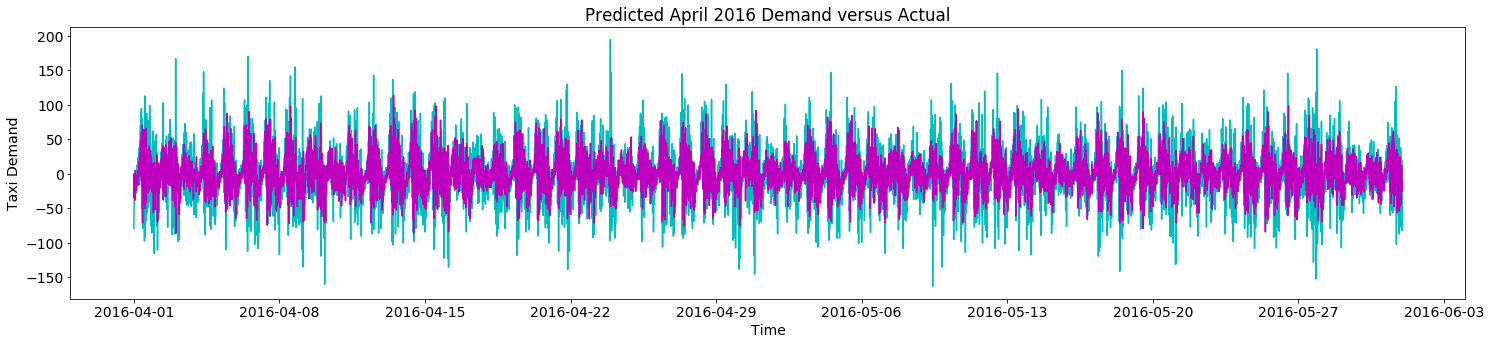

In [167]:
plt.figure(figsize=(25, 5))
plt.plot(test_actual_demand.index, test_actual_demand, color='c')
plt.plot(test_actual_demand.index, predicted_demand, color='m')
plt.title('Predicted April 2016 Demand versus Actual')
plt.xlabel('Time')
plt.ylabel('Taxi Demand');

## Merge original dataset with the demand dataframe

In [ ]:
#Creating the final dataset
taxi_weather_final = taxi_weather_clean

In [ ]:
#Adding demand variable in (joining on the trip_start_timestamp)
taxi_weather_final = taxi_weather_final.merge(demand, how='left', on='trip_start_timestamp')

In [ ]:
#Define features and target variable
features = taxi_weather_final[['trip_start_timestamp', 'trip_miles', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
                          'avg_temp_f', 'fog', 'rain', 'snow']]  #'avg_daily_wind_speed'
target_duration = taxi_weather_final['trip_seconds'] #taxi_weather_final[fare_with_tolls]


## Explore exogenious variables

In [ ]:
taxi_smaller = taxi_weather_final[['trip_start_timestamp', 'trip_miles', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
                          'avg_temp_f', 'fog', 'rain', 'snow', 'trip_seconds', 'fare_with_tolls']]

In [ ]:
taxi_weather_Sept = taxi_smaller[(taxi_smaller['trip_start_timestamp'] >= '2016-09-01 00:00:00') &
                                         (taxi_smaller['trip_start_timestamp'] <= '2016-09-15 23:59:59')]


In [ ]:
sns.pairplot(taxi_weather_Sept)

### Scale the data

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


### Log distance and target variables

In [ ]:
taxi_weather_final.head(2)

In [ ]:
#Given previous analysis, miles, seconds and fare variables all have right-skewed distribution, to fix that I'm logging those three variables
taxi_weather_final['log_trip_miles'] = np.log(taxi_weather_final['trip_miles'])
taxi_weather_final['log_trip_seconds'] = np.log(taxi_weather_final['trip_seconds'])
taxi_weather_final['log_fare_with_tolls'] = np.log(taxi_weather_final['fare_with_tolls'])

In [ ]:
taxi_weather_final['log_trip_miles'].hist(bins=50, color='m')
plt.title('Histogram of logged trip miles')
plt.xlabel('Logged trip miles')
plt.ylabel('Frequency');

## In search for the best model

### Parameter search

In [ ]:
#Ridge
params_ridge = dict(alpha=[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 2.0, 5.0, 10.0])

grid_Ridge = GridSearchCV(Ridge, params_ridge, scoring='RMSE')
grid_Ridge.fit(scaled_features, target_duration);

In [ ]:
# examine the best model
print('Best precision score for Ridge cross validation is', colored(str(round(grid_Ridge.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for Ridge cross validation are:\n\t', colored(str(grid_Ridge.best_params_), 'magenta'))
print('Best estimators for Ridge cross validation are the following:\n\t', colored(str(grid_Ridge.best_estimator_), 'magenta'))

In [ ]:
#Lasso
params_lasso = dict(alpha=[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 2.0, 5.0, 10.0])

grid_Lasso = GridSearchCV(Lasso, params_lasso, scoring='RMSE')
grid_Lasso.fit(scaled_features, target_duration);

In [ ]:
# examine the best model
print('Best precision score for Lasso cross validation is', colored(str(round(grid_Lasso.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for Lasso cross validation are:\n\t', colored(str(grid_Lasso.best_params_), 'magenta'))
print('Best estimators for Lasso cross validation are the following:\n\t', colored(str(grid_Lasso.best_estimator_), 'magenta'))

In [ ]:
#ExtraTrees
params_extraTrees = dict()

grid_ExtraTrees = GridSearchCV(ExtraTrees, params_extraTrees, scoring='RMSE')
grid_ExtraTrees.fit(scaled_features, target_duration);

In [ ]:
# examine the best model
print('Best precision score for ExtraTrees cross validation is', colored(str(round(grid_ExtraTrees.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for ExtraTrees validation are:\n\t', colored(str(grid_ExtraTrees.best_params_), 'magenta'))
print('Best estimators for ExtraTrees validation are the following:\n\t', colored(str(grid_ExtraTrees.best_estimator_), 'magenta'))

In [ ]:
#RandomForest
params_randomForest = dict()

grid_RandomForest = GridSearchCV(RandomForest, params_randomForest, scoring='RMSE')
grid_RandomForest.fit(scaled_features, target_duration);

In [ ]:
# examine the best model
print('Best precision score for RandomForest cross validation is', colored(str(round(grid_RandomForest.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for RandomForest validation are:\n\t', colored(str(grid_RandomForest.best_params_), 'magenta'))
print('Best estimators for RandomForest validation are the following:\n\t', colored(str(grid_RandomForest.best_estimator_), 'magenta'))

In [ ]:
#XGBoost
params_XGBoost = dict()

grid_XGBoost = GridSearchCV(XGBoost, params_XGBoost, scoring='RMSE')
grid_XGBoost.fit(scaled_features, target_duration);

In [ ]:
# examine the best model
print('Best precision score for XGBoost cross validation is', colored(str(round(grid_XGBoost.best_score_, 3)), 'magenta')+ '.')
print('Best parameters for XGBoost validation are:\n\t', colored(str(grid_XGBoost.best_params_), 'magenta'))
print('Best estimators for XGBoost validation are the following:\n\t', colored(str(grid_XGBoost.best_estimator_), 'magenta'))

### Now that I know the best parameters, let's see which model performs the best

In [ ]:
model_list = [LinearRegression(),
              Ridge(),
              Lasso(),
              tree.ExtraTreeRegressor(max_depth=7),
              ensemble.RandomForestRegressor(),
              ensemble.GradientBoostingRegressor()]

model_names = ['LinearRegression', 'Ridge', 'Lasso', 'ExtraTrees', 'RandomForest', 'XGBoost']

In [ ]:
model_RMSEs  = []
model_AdjR2s = []
all_models = {}

for i in range(len(model_list)):
    try_model = model_list[i]
    try_model.fit(scaled_features, target_duration)
    all_models[model_names[i]] = try_model
    model_RMSE = cross_val_score(try_model, scaled_features, target_duration, cv=10,
                                scoring='rmse')
    model_AdjR2 = cross_val_score(try_model, scaled_features, target_duration, cv=10,
                                scoring='r2')
    model_RMSEs.append((model_names[i], round(np.mean(model_RMSE), 3)))
    model_AdjR2s.append((model_names[i], round(np.mean(model_AdjR2), 3)))
    
print('RMSE scores: ' + colored(str(sorted(model_RMSEs, key=lambda x: x[1], reverse=True)), 'green'))
print('Adj. R2 scores: '+ colored(str(sorted(model_AdjR2s, key=lambda x: x[1], reverse=True)), 'green'))

### Learning curve

In [ ]:
plt.figure(figsize=(10, 5))

mse_scores = cross_val_score(car_ad_model_log_fit, X_all_train, y_log, cv=10, scoring='neg_mean_squared_error')
mean_mse_score = -np.mean(mse_scores)

train_sizes, train_scores, test_scores = learning_curve(, , , cv=4)
ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})
print(learn_df, '\n')

plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
plt.title('Learning Curve')
plt.xlabel('No. of data points')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.ylim(-1,1);

### Feature importance using Random Forest

In [ ]:
feat_imp = []
for var, imp in zip([f for f in scaled_features.columns], Random_Forest.feature_importances_):
    feat_imp.append((var, round(imp, 3)))

for var, imp in sorted(feat_imp, key=lambda x: x[1], reverse=True):
    print(str(var)+':', str(imp))

## Finally! Mapping and visualizing :)

In [159]:
def address_to_longlat(address):
    """Takes an address string and converts it into a lat/long.
    Returns longitude and longitude pair."""
    longitude = geocoder.osm(address).latlng[1]
    latitude = geocoder.osm(address).latlng[0]
    return [longitude, latitude]

def address_to_geopoint(address):
    """Takes an address string and converts it into a geopoint.
    Returns a geopoint."""
    geopoint = Point(address_to_latlong(address))
    return geopoint

def get_now():
    """Returns current date/time."""
    now = dt.datetime.now()
    return now

In [161]:
print(get_now())

2018-09-10 22:28:48.594933


In [140]:
# address = '149 new montgomery street, san francisco'
# print(address_to_latlong(address))
# print(address_to_geopoint(address))

[-122.3995767, 37.78697115]
POINT (-122.3995767 37.78697115)


### Update location columns for pickup and dropoff using shapely (converting the dataframe to GeoPandas)

In [ ]:
#replace pickup_centroid_location and dropoff_centroid_location columns with point coordinates using shapely
pickup_geopoint = list(zip(taxi_weather_df['pickup_centroid_longitude'], taxi_weather_df['pickup_centroid_latitude']))
dropoff_geopoint = list(zip(taxi_weather_df['dropoff_centroid_longitude'], taxi_weather_df['dropoff_centroid_latitude']))

taxi_weather_df['pickup_centroid_location'] = pickup_geopoint
taxi_weather_df['dropoff_centroid_location'] = dropoff_geopoint

taxi_weather_df['pickup_centroid_location'] = taxi_weather_df['pickup_centroid_location'].apply(Point)
taxi_weather_df['dropoff_centroid_location'] = taxi_weather_df['dropoff_centroid_location'].apply(Point);


In [ ]:
taxi_weather_df.head(2)

In [ ]:
taxi_weather_gdf = gpd.GeoDataFrame(taxi_weather_df, geometry='pickup_centroid_location')

In [ ]:
taxi_weather_gdf.tail(3)

In [ ]:
# with fiona.drivers():
#     with fiona.open("./Datasets/USA_adm/USA_adm2.shp") as source:
#         meta = source.meta
#         geoms = []
#         for fear in source:
#             geoms.append(fear['geometry'])

In [ ]:
# geoms[1]

In [ ]:
# # usa_shape_link = "./Datasets/LKA_adm/LKA_adm1.shp"
# geo_df = gpd.GeoDataFrame(geoms)
# geo_df.head()

In [ ]:
# geo_df.plot()

In [ ]:
# df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# # We restrict to North America.
# ax = geo_df.plot(
#     color='white', edgecolor='blue')

# # We can now plot our GeoDataFrame.
# taxi_weather_gdf.plot(ax=ax, color='red')
# plt.show()

taxi_weather_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='c')
plt.title('Pickup locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude');